In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil, math
from scipy.stats import pearsonr
from itertools import combinations
from rich import print
import warnings, random
warnings.filterwarnings("ignore")
#from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal
# https://www.statisticshowto.com/ancova/

In [2]:
subjects = [{'Weight': round(random.uniform(50, 100), 1),
             'Height': round(random.uniform(1.5, 1.8), 2)} 
            for _ in range(5)]
df = pd.DataFrame(subjects)



def dp_2d(clean_data, pipeline_output):
    
    loo_output = np.array([
        user_output(clean_data.drop(index=i)) 
        for i in range(len(clean_data))
    ])
    pprint(loo_output.shape, type(loo_output), loo_output)
    loo_scale = np.std(loo_output, axis=0)
    sensitivity = np.max(np.linalg.norm(loo_output - pipeline_output, axis=1))
    cov = np.diag((2 * loo_scale)**2)
    
    while True:
        noise = multivariate_normal(mean=[0, 0], cov=cov).rvs()
        if np.linalg.norm(noise) >= sensitivity:
            break
    
    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity

pipeline_output = user_output(df)
noisy_output, sensitivity = dp_2d(df, pipeline_output)

pprint("Pipeline output:", pipeline_output)
pprint("Noisy DP output:", noisy_output)
pprint("Sensitivity:", sensitivity)


def user_output(data):
    return np.array([
        data['Weight'].mean(),
        data['Height'].mean()
    ])

(5, 2)
<class 'numpy.ndarray'> [[76.      1.6575]
 [80.575   1.66  ]
 [81.375   1.685 ]
 [79.525   1.7025]
 [77.825   1.665 ]]

Pipeline output: [79.06   1.674]

Noisy DP output: [73.17794032  1.72409222]

Sensitivity: 3.0600444849707684

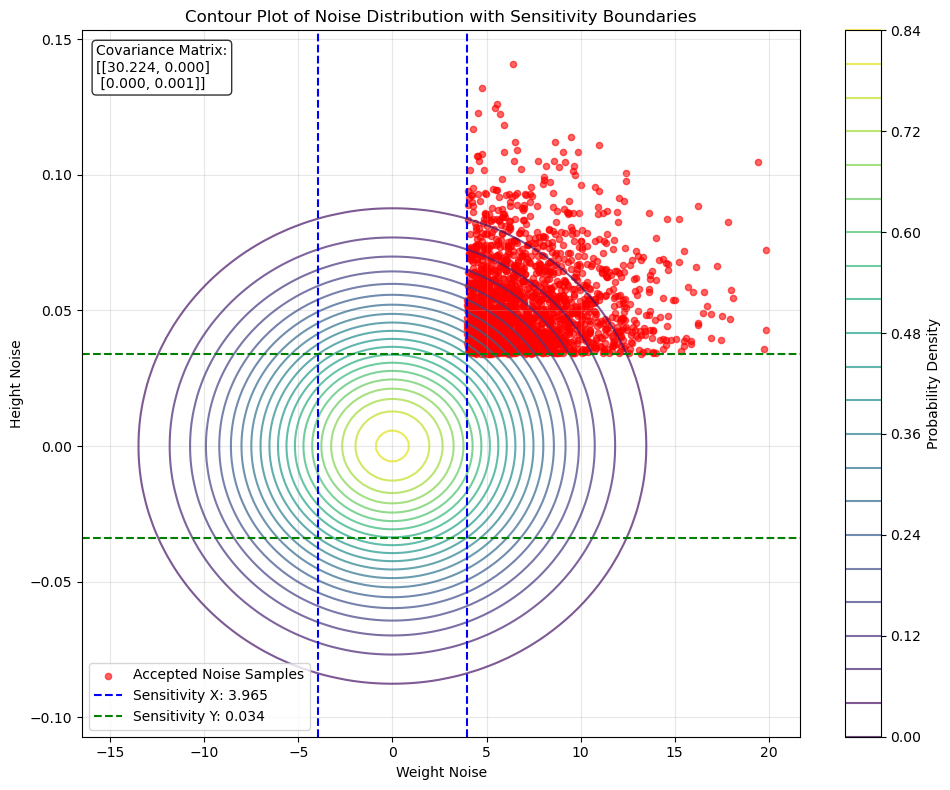

Covariance Matrix:

[[3.02236e+01 0.00000e+00]
 [0.00000e+00 1.27600e-03]]

Sensitivity: [3.965 0.034]

Number of noise samples: 2000

In [6]:

np.random.seed(42)
random.seed(42)

subjects = [{'Weight': round(random.uniform(50, 100), 1),
             'Height': round(random.uniform(1.5, 1.8), 2)} 
            for _ in range(5)]
df = pd.DataFrame(subjects)

def user_output(data):
    return np.array([np.mean(data, axis=0)])

def dp_2d(clean_data, pipeline_output):
    
    loo_output = np.array([np.mean(np.delete(clean_data,i,axis=0), 0) for i in range(clean_data.shape[0])])
    loo_scale = np.std(loo_output, axis=0)
    sensitivity = np.max(np.abs(loo_output - pipeline_output), 0)
    cov = np.diag((2 * loo_scale)**2)

    noise_samples = []
    for _ in range(2000):
        while True:
            noise = multivariate_normal(mean=[0, 0], cov=cov).rvs()
            if np.all(noise >= sensitivity):
                noise_samples.append(noise)
                break
    
    return np.array(noise_samples), sensitivity, cov

noise_samples, sensitivity, cov = dp_2d(df.values, user_output(df.values))

plt.figure(figsize=(10, 8))

x = np.linspace(-3 * np.sqrt(cov[0, 0]), 3 * np.sqrt(cov[0, 0]), 100)
y = np.linspace(-3 * np.sqrt(cov[1, 1]), 3 * np.sqrt(cov[1, 1]), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv = multivariate_normal([0, 0], cov)
Z = rv.pdf(pos)

contour = plt.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Probability Density')

plt.scatter(noise_samples[:, 0], noise_samples[:, 1], alpha=0.6, 
           color='red', s=20, label='Accepted Noise Samples')

plt.axvline(x=sensitivity[0], color='blue', linestyle='--', label=f'Sensitivity X: {sensitivity[0]:.3f}')
plt.axvline(x=-sensitivity[0], color='blue', linestyle='--')
plt.axhline(y=sensitivity[1], color='green', linestyle='--', label=f'Sensitivity Y: {sensitivity[1]:.3f}')
plt.axhline(y=-sensitivity[1], color='green', linestyle='--')

plt.xlabel('Weight Noise')
plt.ylabel('Height Noise')
plt.title('Contour Plot of Noise Distribution with Sensitivity Boundaries')
plt.legend(loc=3)
plt.grid(True, alpha=0.3)

cov_text = f'Covariance Matrix:\n[[{cov[0,0]:.3f}, {cov[0,1]:.3f}]\n [{cov[1,0]:.3f}, {cov[1,1]:.3f}]]'
plt.text(0.02, 0.98, cov_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Covariance Matrix:")
print(cov)
print(f"\nSensitivity: {sensitivity}")
print(f"\nNumber of noise samples: {len(noise_samples)}")

In [5]:
c_mean = [1, 2, 3, 4]
c_cov = [[2, 1, 0.5, 0.3],
             [1, 2, 0.4, 0.2],
             [0.5, 0.4, 2, 0.1],
             [0.3, 0.2, 0.1, 2]]
test = multivariate_normal(mean=c_mean, cov=c_cov, size = 2)
print(test, test.shape)

[[-0.21506478  1.85903313  4.53594641  4.2686937 ]
 [ 0.54640363  0.88878916  1.77278151  4.0459722 ]]
(2, 4)

In [2]:
from numba import njit, prange

#@njit
def user_output(data):
    return np.array([np.mean(data, axis=0)])
def dp_2d(clean_data, pipeline_output):
    
    loo_output = np.array([np.mean(np.delete(df,i,axis=0), 0) for i in range(df.shape[0])])
    loo_scale = np.std(loo_output, axis=0)
    sensitivity = np.max(np.abs(loo_output - pipeline_output), 0)
    cov = np.diag((2 * loo_scale)**2)

    while True:
        noise = multivariate_normal(mean=[0, 0], cov=cov).rvs()
        if np.all(noise >= sensitivity):
            break
    
    noisy_output = pipeline_output + noise
    
    return noisy_output, sensitivity

def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def outlier_(value, lower, upper):
    return value < lower or value > upper

In [3]:
#@njit(parallel=True)
def sim_2d(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes}  
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        subjects = [{'Weight': round(random.uniform(50, 100), 1),
                     'Height': round(random.uniform(1.5, 1.8), 2)} 
                    for _ in range(200)]
        df = pd.DataFrame(subjects)

        for size in subsample_sizes:
            subsample = df.iloc[:size].copy()

            if OL:
                subsample.iloc[0, subsample.columns.get_loc("Weight")] = 10.0 
                subsample.iloc[0, subsample.columns.get_loc("Height")] = 10.0 
            else:
                pass

            true_mean = user_output(subsample)  
            true_means_[size].append(true_mean)
            loo_data = [subsample.drop(index=i) for i in range(len(subsample))]
            
            noisy_outputs = []
            sens_outputs = []
            print("loo start")
            for loo_subset in loo_data:
                output = user_output(loo_subset)
                noisy_output, sensitivity_ = dp_2d(loo_subset, output)
                noisy_outputs.append(noisy_output)
                sens_outputs.append(sensitivity_)
            noisy_outputs = np.array(noisy_outputs)   
            print(print("loo finished"))
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = []
            for dim in range(noisy_outputs.shape[1]):  
                recons_dim = np.linalg.solve(coeff_mat, (size - 1) * noisy_outputs[:, dim])
                recons.append(recons_dim)
            recons = np.stack(recons, axis=1) 
            
            reconstructed[size].append(recons)
            sensitivities_[size].append(sens_outputs)

            subsample_array = subsample[['Weight', 'Height']].to_numpy()
            recons_error = np.mean(np.linalg.norm(recons - subsample_array, axis=1))
            error_[size].append(recons_error)
            iqr_, lower_b, upper_b = iqr_bounds(recons[:,0])
            
            if outlier_(recons[0,0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx,0], lower_b, upper_b):
                    id_dr[size][idx] += 1
                    
    return id_dr, counts, reconstructed, sensitivities_, error_

n_replicates = 1
subsample_sizes = [5]

id_dr, counts, reconstructed, sensitivities_, error_ = sim_2d(n_replicates, subsample_sizes, OL=True)


loo start

NameError: name 'df' is not defined

In [58]:
def dp(clean_data,pipeline_output):

    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity

def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def outlier_(value, lower, upper):
    return value < lower or value > upper

def sim(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        data = np.random.normal(loc=170, scale=10, size=200)
        for size in subsample_sizes:
            subsample = data[:size].copy()
            iqr_, lower_b, upper_b = iqr_bounds(subsample)
            
            if OL:
                outlier_val = lower_b - 100
                subsample[0] = outlier_val

            print(f"subsample: {subsample.shape}")
            true_mean = np.mean(subsample)
            true_means_[size].append(true_mean)
            loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
            ######## PIPELINE ########
            noisy_outputs = []
            sens_outputs = []
            print(f"loo_data: {loo_data.shape}")
            for loo_subset in loo_data:
                output = user_output(loo_subset)
                noisy_output, sensitivity_ = dp(loo_subset, output)
                print(f"here: {noisy_output}, {sensitivity_}")
                noisy_outputs.append(noisy_output)
                sens_outputs.append(sensitivity_)
            print(f"noisy output: {np.array(noisy_outputs).shape}")    
            ######## RECONSTRUCTION ########
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))
            iqr_, lower_b, upper_b = iqr_bounds(recons)

            
            recons_error = np.mean(abs(recons - subsample))
            error_[size].append(recons_error)
            sensitivities_[size].append(sens_outputs)
            reconstructed[size].append(recons)
            print(f"sens: {np.array(sensitivities_[size]).shape}")
            if outlier_(recons[0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx], lower_b, upper_b):
                    id_dr[size][idx] += 1
            print("*"*50)
        print(f"end run #: {n}")
        print("*"*70)
    return id_dr, counts, reconstructed, sensitivities_, error_

n_replicates = 2
subsample_sizes = [5, 10]

id_dr, counts, reconstructed, sensitivities_, error_ = sim(n_replicates, subsample_sizes, OL=False)
# n number of samples, should return n number of sens values, 
# then n,k number of samples, should return n, k number of sens values


subsample: (5,)

loo_data: (5, 4)

here: 178.56571881475762, 5.056882245936379

here: 181.30720440159203, 4.528737648633353

here: 170.89324123313082, 2.063087404813075

here: 178.74320822476136, 4.476592088423359

here: 168.05246756004607, 4.102229595939377

noisy output: (5,)

sens: (1, 5)

**************************************************

subsample: (10,)

loo_data: (10, 9)

here: 171.52692230062402, 2.2596095563715153

here: 181.65000923177885, 2.1715854568210204

here: 171.14022374972657, 2.4259314919894734

here: 178.69981343735023, 2.162894530119331

here: 179.8716404040188, 2.1005007813720056

here: 178.3198384178371, 2.202495026368126

here: 169.47243989335357, 2.1260607168688637

here: 176.278022786803, 2.369574487420124

here: 173.1201014996078, 2.2119745550318157

here: 170.1248895166103, 2.503828325295302

noisy output: (10,)

sens: (1, 10)

**************************************************

end run #: 0

**********************************************************************

subsample: (5,)

loo_data: (5, 4)

here: 188.9471576969864, 4.394167223812502

here: 183.20218665498155, 6.211069270430073

here: 181.1706289506367, 5.886744136107637

here: 159.22348089159954, 4.1418533766911025

here: 180.5427730689291, 5.762691687536801

noisy output: (5,)

sens: (2, 5)

**************************************************

subsample: (10,)

loo_data: (10, 9)

here: 177.77441900066066, 1.7964225029936074

here: 170.62559287354523, 2.168770789488633

here: 167.99637327135613, 2.2881795571329633

here: 169.03873054325746, 2.104016039613782

here: 176.3733883128773, 2.2675041490378476

here: 169.32046008678506, 2.26005181856803

here: 168.93135913370793, 2.2521314441243874

here: 170.51824421455493, 2.198202565413311

here: 168.7789448040158, 2.2274766369139627

here: 178.4983911374488, 2.3492735748200744

noisy output: (10,)

sens: (2, 10)

**************************************************

end run #: 1

**********************************************************************

In [ ]:
df_cleaned = df

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.regplot(x='age', y='Weight', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Weight'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 2)
sns.regplot(x='age', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 3)
sns.regplot(x='Weight', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['Weight'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()

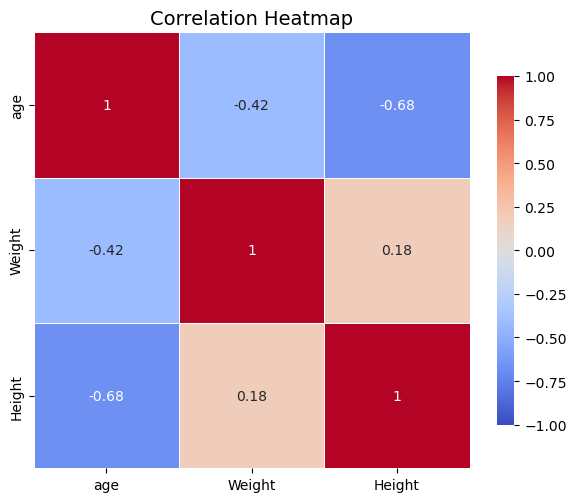

In [147]:
cor_mat = df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()


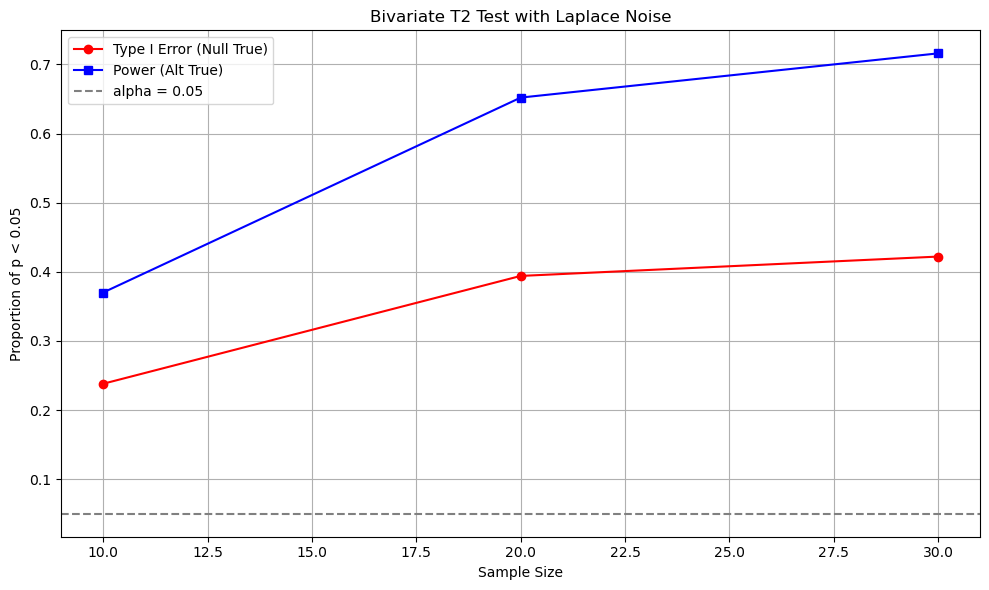

In [151]:
from scipy.stats import f, multivariate_normal

def noisy_t2_test(X, mu0, noise_scale=0.5, add_cov_noise=True):
    n, p = X.shape
    x_bar = np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)

    noisy_mean = x_bar + np.random.laplace(0, noise_scale, size=p)

    if add_cov_noise:
        noise_matrix = np.random.laplace(0, noise_scale, size=(p, p))
        noise_matrix = (noise_matrix + noise_matrix.T) / 2  
        noisy_cov = S + noise_matrix
    else:
        noisy_cov = S

    diff = noisy_mean - mu0
    try:
        T2 = n * diff.T @ np.linalg.inv(noisy_cov) @ diff
    except np.linalg.LinAlgError:
        return np.nan, np.nan

    F_stat = (n - p) / (p * (n - 1)) * T2
    pval = 1 - f.cdf(F_stat, dfn=p, dfd=n - p)
    return T2, pval

n_replicates = 500
sample_sizes = [10, 20, 30]
mu0 = np.array([0, 0])
mu1 = np.array([0.5, 0.5])
cov = np.array([[1, 0.5], [0.5, 1]])
noise_scale = 0.3

type1_rates = []
power_rates = []

for n in sample_sizes:
    type1, power = [], []
    for _ in range(n_replicates):
        X_null = np.random.multivariate_normal(mu0, cov, size=n)
        X_alt = np.random.multivariate_normal(mu1, cov, size=n)

        _, pval_null = noisy_t2_test(X_null, mu0, noise_scale=noise_scale, add_cov_noise=True)
        _, pval_alt = noisy_t2_test(X_alt, mu0, noise_scale=noise_scale, add_cov_noise=True)

        if not np.isnan(pval_null):
            type1.append(pval_null < 0.05)
        if not np.isnan(pval_alt):
            power.append(pval_alt < 0.05)

    type1_rates.append(np.mean(type1))
    power_rates.append(np.mean(power))

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, type1_rates, marker='o', color='red', label='Type I Error (Null True)')
plt.plot(sample_sizes, power_rates, marker='s', color='blue', label='Power (Alt True)')
plt.axhline(0.05, linestyle='--', color='gray', label='alpha = 0.05')
plt.xlabel('Sample Size')
plt.ylabel('Proportion of p < 0.05')
plt.title("Bivariate T2 Test with Laplace Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


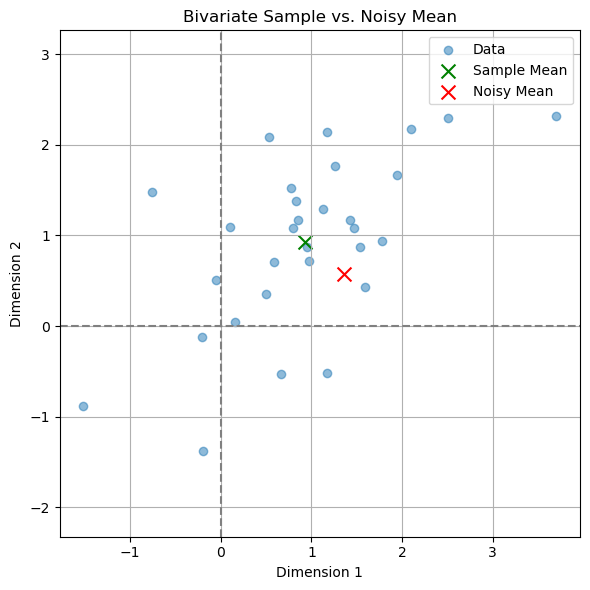

In [3]:
X = np.random.multivariate_normal(mu1, cov, size=30)
sample_mean = np.mean(X, axis=0)
noisy_mean = sample_mean + np.random.laplace(0, noise_scale, size=2)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data')
plt.scatter(*sample_mean, color='green', label='Sample Mean', s=100, marker='x')
plt.scatter(*noisy_mean, color='red', label='Noisy Mean', s=100, marker='x')
plt.axhline(mu0[1], linestyle='--', color='gray')
plt.axvline(mu0[0], linestyle='--', color='gray')
plt.title('Bivariate Sample vs. Noisy Mean')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


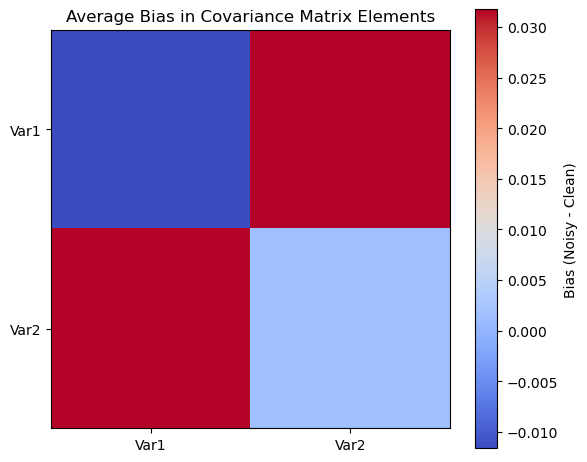

In [148]:
from numpy.linalg import eigh

n_samples = 50
n_replicates = 300
mu = np.array([0, 0])
cov_true = np.array([[1, 0.8], [0.8, 1]])
noise_scale = 0.3

clean_covs = []
noisy_covs = []
t2_clean = []
t2_noisy = []

for _ in range(n_replicates):
    X = np.random.multivariate_normal(mu, cov_true, size=n_samples)
    
    mean = np.mean(X, axis=0)
    S_clean = np.cov(X, rowvar=False)
    S_noisy = S_clean + np.random.laplace(0, noise_scale, size=(2, 2))
    S_noisy = (S_noisy + S_noisy.T) / 2  

    diff = mean - mu
    T2_clean = n_samples * diff.T @ np.linalg.inv(S_clean) @ diff
    T2_noisy = n_samples * diff.T @ np.linalg.inv(S_noisy) @ diff

    clean_covs.append(S_clean)
    noisy_covs.append(S_noisy)
    t2_clean.append(T2_clean)
    t2_noisy.append(T2_noisy)

clean_covs = np.array(clean_covs)
noisy_covs = np.array(noisy_covs)

bias_matrix = np.mean(noisy_covs - clean_covs, axis=0)

plt.figure(figsize=(6, 5))
plt.imshow(bias_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Bias (Noisy - Clean)')
plt.title('Average Bias in Covariance Matrix Elements')
plt.xticks([0,1], ['Var1', 'Var2'])
plt.yticks([0,1], ['Var1', 'Var2'])
plt.tight_layout()
plt.show()



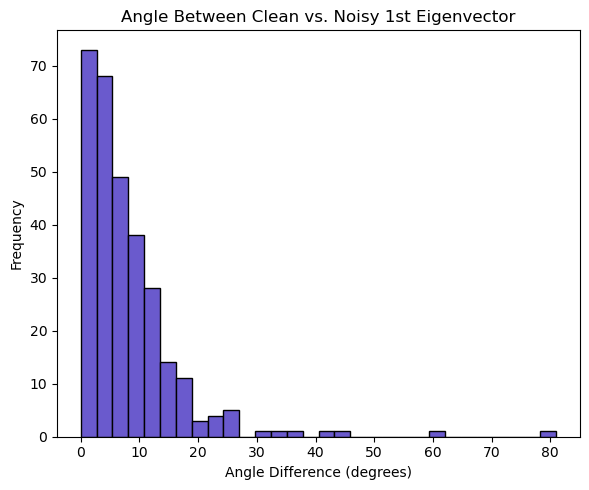

In [149]:

eig_diffs = []

for i in range(n_replicates):
    _, vecs_clean = eigh(clean_covs[i])
    _, vecs_noisy = eigh(noisy_covs[i])
    angle_diff = np.arccos(np.clip(np.abs(np.dot(vecs_clean[:, 1], vecs_noisy[:, 1])), -1, 1))
    eig_diffs.append(np.degrees(angle_diff))

plt.figure(figsize=(6, 5))
plt.hist(eig_diffs, bins=30, color='slateblue', edgecolor='black')
plt.title('Angle Between Clean vs. Noisy 1st Eigenvector')
plt.xlabel('Angle Difference (degrees)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


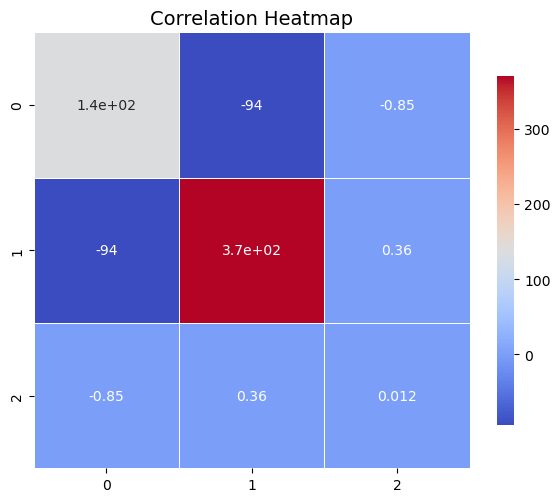

In [153]:
cor_mat = np.array(df.cov())

plt.figure(figsize=(6, 5))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm',
           square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
subjects = [{'age': random.randint(15, 50), 
           'Weight': round(random.uniform(50, 100), 1),
           'Height': round(random.uniform(1.5, 1.8), 2)} 
          for _ in range(500)]

df = pd.DataFrame(subjects)
df


df.cov()

,age,Weight,Height
age,101.508281,-0.282333,0.022652
Weight,-0.282333,210.633984,-0.030368
Height,0.022652,-0.030368,0.007667


In [8]:

def c_cov(subjects):

    ages = np.array([subject['age'] for subject in subjects])
    weights = np.array([subject['Weight'] for subject in subjects])
    heights = np.array([subject['Height'] for subject in subjects])
    data_matrix = np.column_stack((ages, weights, heights))
    means = np.mean(data_matrix, axis=0)
    centered_data = data_matrix - means
    n = len(subjects)
    cov_matrix = (centered_data.T @ centered_data) / (n - 1)
    
    return cov_matrix



Covariance matrix (manual calculation):

[[ 1.04859623e+02 -8.42437675e-01  7.67134269e-05]
 [-8.42437675e-01  1.98236509e+02 -1.26672265e-02]
 [ 7.67134269e-05 -1.26672265e-02  7.24976794e-03]]

Shape: (3, 3)

Covariance matrix (numpy.cov):

[[ 1.04859623e+02 -8.42437675e-01  7.67134269e-05]
 [-8.42437675e-01  1.98236509e+02 -1.26672265e-02]
 [ 7.67134269e-05 -1.26672265e-02  7.24976794e-03]]

Matrices are approximately equal: True

Variances:

Age variance: 104.86

Weight variance: 198.24

Height variance: 0.0072

Covariances:

Age-Weight covariance: -0.84

Age-Height covariance: 0.0001

Weight-Height covariance: -0.0127